## Importing Libraries and Functions

In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

2022-12-05 18:59:35.164522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.10.0


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Hyperparameters

In [4]:
IMAGE_SIZE = 16
EPOCHS = 60
BATCH = 10
LR = 1e-4

PATH = "/Users/shirleychen/Documents/Fall2022/CS229/dataset2/model/"

## Dataset

In [5]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "maskedlabels2/*")))
    
    total_size = len(images)
    print(total_size)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [8]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

16386
Training data:  13110
Validation data:  1638
Testing data:  1638


In [9]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

## Model

In [10]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [11]:
model = model()
model.load_weights('./CNN_model_trouble')

2022-12-05 18:59:42.832304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Metrics

In [12]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def pixel_accuracy(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    z = y_true == y_pred
    z_tot = np.sum(z)
    per = z_tot/len(y_true)
    return per

In [13]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

## Evaluation

In [14]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

# model.evaluate(test_dataset, steps=test_steps)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]


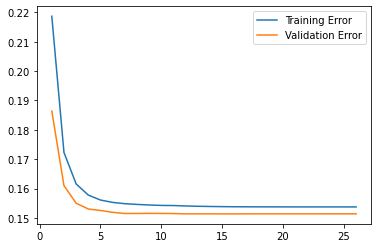

In [15]:
training_hist = np.load('training_hist.npy', allow_pickle = True)
training_hist = training_hist.tolist()
epoch = np.arange(len(training_hist['loss']))+1
print(epoch)
plt.figure()
plt.plot(epoch,training_hist['loss'],epoch,training_hist['val_loss'])
plt.legend(['Training Error','Validation Error'])

## Results

In [16]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [17]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [18]:
# for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
#     x = read_image(x)
#     y = read_mask(y)
#     y_pred = model.predict(np.expand_dims(x, axis=0))#[0] > 0.5
#     h, w, _ = x.shape
#     white_line = np.ones((h, 10, 3))

#     all_images = [
#         x, white_line,
#         mask_parse(y), white_line,
#         mask_parse(y_pred)
#     ]
#     image = np.concatenate(all_images, axis=1)
    
#     fig = plt.figure(figsize=(12, 12))
#     a = fig.add_subplot(1, 1, 1)
#     imgplot = plt.imshow(image)

In [19]:
def mul(x):
    x = np.ceil(x*255)
    x = np.reshape(x,(IMAGE_SIZE, IMAGE_SIZE))
    return x

In [20]:
def to_rgb(x):
    y = np.zeros((IMAGE_SIZE,IMAGE_SIZE,3))
    for i in range(IMAGE_SIZE):
        for j in range(IMAGE_SIZE):
            if x[i,j] == 0:
                y[i,j,:] = [0,0,0]
            elif x[i,j] == 64:
                y[i,j,:] = [64,64,64]
            elif x[i,j] == 128:
                y[i,j,:] = [128,128,128]
            elif x[i,j] == 192:
                y[i,j,:] = [192,192,192]
            else:
                y[i,j,:] = [255,255,255]
    return y
def to_rgb2(x):
    y = np.zeros((IMAGE_SIZE,IMAGE_SIZE,3))
    for i in range(IMAGE_SIZE):
        for j in range(IMAGE_SIZE):
            if x[i,j] == 0:
                y[i,j,:] = [0,0,0]
            elif x[i,j] == 1:
                y[i,j,:] = [255,0,0]
            elif x[i,j] == 2:
                y[i,j,:] = [0,255,0]
            elif x[i,j] == 3:
                y[i,j,:] = [0,0,255]
            else:
                y[i,j,:] = [255,255,255]
    return y

In [21]:
def accuracy(x,y):
    z = x == y
    trues = np.sum(z)
    percent = trues/(256*256*3)
    return percent

1/1 [==============================] - 1s 685ms/step
[0.47058824 0.54901961 0.58823529 0.70588235 0.7372549  1.        ]
[0.99904346 0.99905926 0.99907994 0.9990817  0.99908984 0.9990903
 0.999112   0.999115   0.999116   0.9991289  0.99913555 0.99914247
 0.99915135 0.9991543  0.9991629  0.9991645  0.9991646  0.99917156
 0.9991774  0.9991784  0.99917907 0.9991806  0.99918646 0.99918795
 0.9991887  0.9991919  0.9991937  0.99919856 0.99920547 0.99920624
 0.9992072  0.9992078  0.99921215 0.99921364 0.9992155  0.9992287
 0.9992324  0.99923617 0.9992382  0.9992388  0.99924225 0.99924374
 0.9992449  0.9992451  0.9992453  0.9992473  0.9992488  0.9992516
 0.9992517  0.99925256 0.99925494 0.999256   0.99925697 0.9992578
 0.9992585  0.99926233 0.99926305 0.9992642  0.99926573 0.99926716
 0.9992701  0.9992747  0.9992769  0.99927735 0.99927765 0.9992783
 0.99927896 0.99928707 0.99928796 0.999288   0.9992934  0.9992959
 0.999297   0.9992996  0.9993031  0.9993034  0.9993041  0.9993058
 0.9993078  0.9

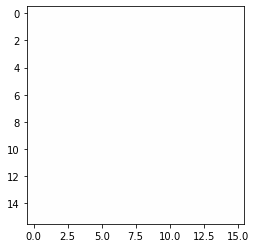

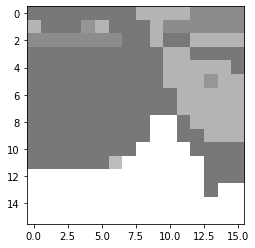

In [22]:
x = read_image(test_x[64])
y = read_mask(test_y[64])
b = np.repeat(y, 3, axis=2)
y_pred = model.predict(np.expand_dims(x, axis=0))
print(np.unique(y))
print(np.unique(y_pred))
y_pred = np.reshape(y_pred,[IMAGE_SIZE,IMAGE_SIZE,1])
print(y_pred.shape)
c = np.repeat(y_pred, 3, axis=2)
plt.figure()
plt.imshow(c)
plt.figure()
plt.imshow(b)
# y = mul(y)
# y = to_rgb(y)
# y_pred = model.predict(np.expand_dims(x, axis=0))
# y_pred = mul(y_pred)
# y_pred = to_rgb2(y_pred)

In [23]:
print(1+1)

2


1/1 [==============================] - 0s 21ms/step


0.0

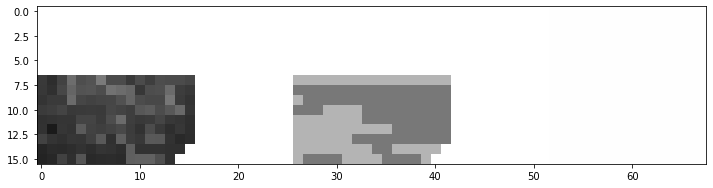

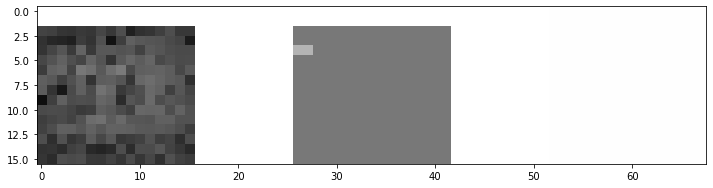

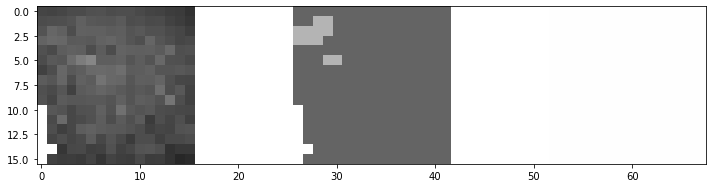

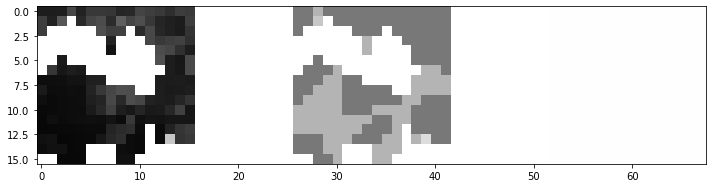

In [24]:
acc = []
for i, (x, y) in enumerate(zip(test_x[16:20], test_y[16:20])):
    x = read_image(x)
    y = read_mask(y)
    y = np.repeat(y, 3, axis=2)
#    y = mul(y)
#    y = to_rgb(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))
    y_pred = np.reshape(y_pred,[IMAGE_SIZE,IMAGE_SIZE,1])
    y_pred = np.repeat(y_pred, 3, axis=2)
#    y_pred = mul(y_pred)
#    y_pred = to_rgb2(y_pred)
#     plt.figure()
#     plt.imshow(x)
#     plt.figure()
#     plt.imshow(y)
#     plt.figure()
#     plt.imshow(y_pred)
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        y, white_line,
        y_pred
    ]
    image = np.concatenate(all_images, axis=1)
    
    acc.append(accuracy(y,y_pred))
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

np.mean(acc)